
## Load HRET ssh, compute basic statistics about ssh and currents


In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import numpy as np
import xarray as xr
from utide._ut_constants import ut_constants as utide

from utils import *

# useful variables
g=9.81
cpd=2.*np.pi/86400. # from cpd to radian/s
crs = ccrs.PlateCarree() # cartopy

#datadir = '/home2/pharos/othr/aponte/tides/HRET/'
datadir = './'

In [2]:
# load hret for one constituent
hret = xr.open_dataset(datadir+'Carrere_HRET_testing.nc',chunks={'longitude': 500, 'latitude': 500})
#hret = hret.sel(longitude=slice(140.,270.),latitude=slice(-40.,40.))
print(hret)

<xarray.Dataset>
Dimensions:    (latitude: 2640, longitude: 7200)
Coordinates:
  * longitude  (longitude) float64 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 ...
  * latitude   (latitude) float64 -66.0 -65.95 -65.9 -65.85 -65.8 -65.75 ...
Data variables:
    M2re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    M2im       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    K1re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    K1im       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    S2re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    S2im       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    O1re       (latitude, longitude) float64 dask.array<shape=(2640, 7200), chunksize=(500, 500)>
    O1im       (latitude, longitude) float64 dask.array<shape=(

In [3]:
# consituents
constituents = ['M2','N2','S2','K1','O1','P1']

omega = dict()
for cst,o in zip(utide['const']['name'], utide['const']['freq']):
    if cst in constituents:
        omega[cst] = o*24. # cpd, input frequencies are cph
        print(cst+' omega=%e rad/s, %.3f cpd'%(o*2.*np.pi/3600., o*24.))

O1 omega=6.759774e-05 rad/s, 0.930 cpd
P1 omega=7.252295e-05 rad/s, 0.997 cpd
K1 omega=7.292116e-05 rad/s, 1.003 cpd
N2 omega=1.378797e-04 rad/s, 1.896 cpd
M2 omega=1.405189e-04 rad/s, 1.932 cpd
S2 omega=1.454441e-04 rad/s, 2.000 cpd


In [4]:
# load bathymetry and a minimum water for analysis
h = load_bathy(lon=hret.longitude, lat=hret.latitude)
hc=1000. # locations with depth lower than hc are not considered in statistics

---

# Divergence


We compute first velocities according to:
\begin{aligned}
u_c = -g \frac{i\tilde\omega\partial_x \eta_c -f \partial_y \eta_c}{\tilde\omega^2 - f^2}, \\
v_c = -g \frac{f\partial_x \eta_c + i \tilde\omega \partial_y \eta_c}{\tilde\omega^2 - f^2},
\end{aligned}
where $\tilde\omega=\omega+ir$.

The divergence is then computed: $\delta=\partial_x u_c + \partial_y v_c = -ig\tilde\omega\Delta \eta_c/(\tilde\omega^2 - f^2)$

From Dunphy et al. 2017:
\begin{aligned}
\partial_t p_n &= - c_n^2 \nabla \cdot u_n + I_n^p, \\
p(z=0) &= \sum_n p_n \phi_n(z=0) \\
&= g \eta
\end{aligned}
Assuming mode 1 dominates:
\begin{aligned}
p &\sim p_1 \phi_1 \\
u &\sim u_1 \phi_1
\end{aligned}



---

## Look first at M2


In [5]:
from utils import *

# compute Coriolis frequency
f = 2*omega['K1']*cpd*np.sin(np.pi/180.*hret['latitude'])
#
cst = 'M2'
r = 1./20./86400. 
omegat = omega[cst]*cpd + np.complex(0.,1.)*r
eta_c = ri2c(hret[cst+'re'],hret[cst+'im'])
if False:
    #
    detadx_c, detady_c = grad(eta_c)
    u_c, v_c = mom_inv(detadx_c, detady_c, f, omega[cst]*cpd)
    #
    dudx_c, dudy_c = grad(u_c)
    dvdx_c, dvdy_c = grad(v_c)
    delta = dudx_c + dvdx_c
else:
    delta = lap(eta_c)*(-np.complex(0.,1.)*g*omegat/(omegat**2-f**2))

/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  elif np.issubdtype(dtype, int):
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:29: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif np.issubdtype(dtype, complex):


/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/Users/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


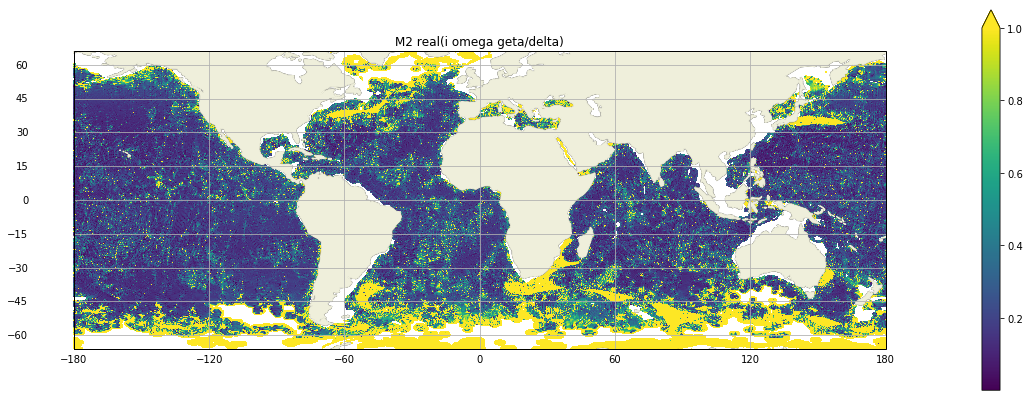

In [6]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection=crs)
#
c2 = np.complex(0.,1.)*omega[cst]*cpd*g*eta_c/delta
toplt = np.abs(1./c2)
toplt = toplt.where(h>hc)
toplt.plot(vmax=1.)
ax.set_title(cst+' real(i omega geta/delta)')
gl=ax.gridlines(crs=crs, draw_labels=True) 
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
plt.show()
